In [1]:
import collections
import random
from random import  uniform
from math import *
import scipy.optimize as opt
import math 
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
import warnings
import numpy as np
import multiprocessing
import pickle

multiprocessing.set_start_method('fork')
warnings.filterwarnings("ignore", category=RuntimeWarning)

### Auxiliary Functions

In [2]:
def write_dict(d):
    with open('data.pkl', 'wb') as file:
        pickle.dump(d, file)
        
def read_dict():
    with open('data.pkl', 'rb') as file:
        loaded_dict = pickle.load(file)
    return loaded_dict

In [3]:
def Hi(v):
    if v==1:
        return 0.5
    return fsolve(lambda x:v -(-x*log2(x)-(1-x)*log2(1-x)),0.0000001)[0]

def H(c):
    """
    Entropy function
    """
    if c == 0. or c == 1.:
        return 0.
    
    if c < 0. or c > 1.:
        return -1000
    
    return -(c * log2(c) + (1 - c) * log2(1 - c))

def binomH(n,k):
    """
    binomial coefficient
    """
    # if k/n not in ZZ:
    #     return -100
    if(n<=0):
        return 0.
    return n * H(k/n)


# Permutation-based ISD

#### Prange SD

In [4]:
def prange(k,w):
    # exploit symmetry in case weight larger than 1/2
    if w>0.5:
        w=1-w
    # polynomial regime
    if w>(1-k)/2 and w<(1+k)/2:
        return 0
    
    # time in case w>n-k, implies there must be p>0
    if w>1-k:
        def time(p):
            return binomH(1,w)-binomH(1-k,w-p)
        return opt.fminbound(time, w-(1-k),w, xtol=1e-10, full_output=1)[1]

    return binomH(1,w)-binomH(1-k,w)

def prange_sd(k,w):
    # prange time with speedup in number of solutions
    return max(prange(k,w)-max(binomH(1,w)-(1-k),0),0)

def prange_reg(k,w):
    # ISD prange applied to RSD with regularity encoded
    if k<w:
        return 0
    return max(prange(k-w,w)-max(log2(1/w)*w-(1-k),0),0)

#### Perm (Section 4.1)

In [5]:
def sample_per_block(k,w):
    # time for RSD permutations
    return w*log2(1/(1-k))

def time_perm_rsd(k,w):
    # time for updated dimension with linear speedup in number of solutions
    return max(sample_per_block(k-w,w)-max(log2(1/w)*w-(1-k),0),0)

# Optimization Specific Functions

From here on we use numerical optimization programs with multiple optimization parameters.
We therefore specify some additional auxiliary functions

In [6]:
#dimension and weight functions used globally by the optimization programs
k = lambda x : 1
w = lambda x : 1

# block length in k+ell part
v = lambda x : ((k(x)+x.ell)/x.N)

# overall block length
b = lambda x : (1/w(x))

In [7]:
def wrap(f,g) :
    def inner(x):
        return f(g(*x))
    return inner

def r(x,y,z):
    return [(uniform(x,y)) for i in range(z)]

def time_opt(kp,wp,time,memory,constraints,num_vars,iterations=30,give_x=0):
    """
    time and constraints define optimization program with goal to minimize time while ensuring all constraints
    memory is function that thakes the optimization parameters returning memory of the algorithm
    num_vars specifies number of optimization parameters
    iterations specify how often optimization is run (best result is returned)
    kp, wp define dimension and weight (regularity is encoded by the time_opt function)
    """
    
    kp=max(0,kp-wp)
    
    # sets k, w functions used by time and constraints 
    global k,w
    k = lambda x : kp
    w = lambda x : wp
    
    # polynomial regime
    if k([])<0:
        return 0
    
    # minimize over multiple runs of the optimizer
    res=1000
    ress=1000
    for j in range(iterations):

        # set random starting points and bounds    
        start=r(0,0.009,num_vars)
        bounds=[(0,1)]*num_vars

        # optimize and store minimum
        result = opt.minimize(time, start, 
                bounds= bounds, tol=1e-8, 
                constraints=constraints, options={'maxiter':2000})
        tmp = result.get('fun')
        if(tmp < res and tmp >0 and result.success):
            res = tmp
            ress = result
            
    # return full output (for debugging)
    if give_x:
        return ress
    
    #return time and memory
    return [res,memory(ress.x)]

# Enumeration-based ISD (Section 4.2)

In [8]:
# ell, p as in the paper
# N is the number of blocks used to sample from for the k+ell part
set_vars_enum = collections.namedtuple('ENUM', 'ell p N')

def enum(f) : return wrap(f, set_vars_enum)

def time_enum_par(x):
    x=set_vars_enum(*x)
    
    # some constraints to ensure computations are well defined
    # those are covered (even more strict) in the constraints array, but it is not ensured
    # that the time_enum_par function is only called on parameters satisfying the constraint array
    # while a final solution is of course only valid if the constraint array is fully satisfied
    if(b(x)-v(x))<1e-10:
        return 1000
    if x.p>x.N or v(x)/b(x)<=0 or 1-v(x)/b(x)<=0:
        return 1000
    
    # probability of having x.p blocks out of x.N with weight and x.N-x.p with weight zero
    prob = binomH(x.N,x.p)+log2(1-v(x)/b(x))*(x.N-x.p) +log2(v(x)/b(x))*x.p
    # list size
    L1=binomH(x.N/2,x.p/2)+log2(v(x))*x.p/2
    # matches
    L = 2*L1 - x.ell
    
    return max(L1,L)-prob

def memory_enum_par(x):
    x=set_vars_enum(*x)
    L1=binomH(x.N/2,x.p/2)+log2(v(x))*x.p/2
    return L1

constraints_enum = [
    
    # bounds on variables
    { 'type' : 'ineq',   'fun' : enum(lambda x : 1-(x.ell+k([])))},
    { 'type' : 'ineq',   'fun' : enum(lambda x : w(x)-x.N)},
    
    # to always sample from all blocks comment next line and uncomment the one after
    { 'type' : 'ineq',   'fun' : enum(lambda x : x.N-x.p)},
    #{ 'type' : 'eq',   'fun' : enum(lambda x : x.N-x.p)},
    
    
    # blocks of width at least one
    { 'type' : 'ineq',   'fun' : enum(lambda x : b(x)-v(x)-1)},
    { 'type' : 'ineq',   'fun' : enum(lambda x : v(x)-0.9999)},
      

]

def time_enum(k,w):
    # outputs time and memory to solve RSD via Enum
    return time_opt(k,w,time_enum_par,memory_enum_par,constraints_enum,3,iterations=40,give_x=0)


# Representation-based ISD

#### Depth 3 (Section 4.3)

In [9]:
set_vars_bj = collections.namedtuple('REP', 'ell p d1 d2 N')

def rep(f) : return wrap(f, set_vars_bj)

def representations(ell,p_target,p_addends,x):
    x=set_vars_bj(*x)
    return binomH(p_target, p_target/2)+binomH(ell-p_target,p_addends-p_target/2)+log2(v(x))*(p_addends-p_target/2)

# weight on each level (root level is level 0 with weight x.p)
p1 = lambda x: x.p/2      + x.d1
p2 = lambda x: p1(x) / 2  + x.d2
p3 = lambda x: p2(x) / 2

# representations ri from level i to level i-1
r1 = lambda x: representations(x.N, x.p  , p1(x), x)
r2 = lambda x: representations(x.N, p1(x), p2(x), x)

# list sizes on each level
L1 = lambda x: binomH(x.N  ,p1(x))+log2(v(x))*p1(x) - r1(x)
L2 = lambda x: binomH(x.N  ,p2(x))+log2(v(x))*p2(x) - r2(x)
L3 = lambda x: binomH(x.N/2,p3(x))+log2(v(x))*p3(x)

# time Ti to construct lists on level i
T1 = lambda x: max(2*L1(x) - ( x.ell - r1(x)), L1(x))
T2 = lambda x: max(2*L2(x) - ( r1(x) - r2(x)), L2(x))
T3 = lambda x: max(2*L3(x) - ( r2(x        )), L3(x))


                      
def time_rep_par(x):
    x=set_vars_bj(*x)  
    
    # ensuring block length on k+ell part is not larger than overall block length
    if v(x)/b(x)>=1:
        return 1000
    
    #probability as in enum
    prob = binomH(x.N,x.p)+log2(1-v(x)/b(x))*(x.N-x.p) +log2(v(x)/b(x))*x.p

    return max(T1(x),T2(x),T3(x))-prob

def memory_rep_par(x):
    x=set_vars_bj(*x)
    return max(L3(x),L2(x),L1(x))

constraints_rep = [
    
    # representation constraints
    { 'type' : 'ineq',   'fun' : rep(lambda x : x.ell-r1(x))},
    { 'type' : 'ineq',   'fun' : rep(lambda x : r1(x)-r2(x))},
    
    # bounds on variables
    { 'type' : 'ineq',   'fun' : rep(lambda x : 1-(x.ell+k([])))},
    # for considering always all blocks in the permutation switch next both lines
    #{ 'type' : 'ineq',   'fun' : rep(lambda x : w(x)-x.N)},
    { 'type' : 'eq',   'fun' : rep(lambda x : w(x)-x.N)},
    
    # blocks of width at least 1 
    { 'type' : 'ineq',   'fun' : rep(lambda x : b(x)-v(x)-1)},
    { 'type' : 'ineq',   'fun' : rep(lambda x : v(x)-1)},
    
    # weight on each level + weight that cancels must fit into the N blocks
    { 'type' : 'ineq',   'fun' : rep(lambda x : x.N-p2(x))},
    { 'type' : 'ineq',   'fun' : rep(lambda x : x.N-p1(x)-x.d2)},
    { 'type' : 'ineq',   'fun' : rep(lambda x : x.N-x.p-x.d1)},
    
]

def time_rep(k,w):
    # outputs time and memory to solve RSD via Rep depth 3
    return time_opt(k,w,time_rep_par,memory_rep_par,constraints_rep,5,iterations=100,give_x=0)



#### Depth 4

Does not lead to improvement over Rep depth 3 (just for completness)

In [10]:
set_vars_rep_d4 = collections.namedtuple('BJMM', 'ell p d1 d2 d3 N')

def rep_d4(f) : return wrap(f, set_vars_rep_d4)


def representations_d4(ell,p_target,p_addends,x):
    x=set_vars_rep_d4(*x)
    return binomH(p_target, p_target/2)+binomH(ell-p_target,p_addends-p_target/2)+log2(v(x))*(p_addends-p_target/2)

# weight on each level (root level is level 0 with weight x.p)
p1_d4 = lambda x: x.p/2      + x.d1
p2_d4 = lambda x: p1_d4(x) / 2  + x.d2
p3_d4 = lambda x: p2_d4(x) / 2  + x.d3
p4_d4 = lambda x: p3_d4(x) / 2

# representations ri from level i to level i-1
r3_d4 = lambda x: representations_d4(x.N, p2_d4(x), p3_d4(x), x)
r2_d4 = lambda x: representations_d4(x.N, p1_d4(x), p2_d4(x), x)
r1_d4 = lambda x: representations_d4(x.N, x.p     , p1_d4(x), x)

# list sizes on each level
L4_d4 = lambda x: binomH(x.N/2,p4_d4(x))+log2(v(x))*p4_d4(x)
L3_d4 = lambda x: binomH(x.N  ,p3_d4(x))+log2(v(x))*p3_d4(x) - r3_d4(x)
L2_d4 = lambda x: binomH(x.N  ,p2_d4(x))+log2(v(x))*p2_d4(x) - r2_d4(x)
L1_d4 = lambda x: binomH(x.N  ,p1_d4(x))+log2(v(x))*p1_d4(x) - r1_d4(x)

# time Ti to construct lists on level i
T4_d4 = lambda x: max(2*L4_d4(x) - ( r3_d4(x           )), L4_d4(x))
T3_d4 = lambda x: max(2*L3_d4(x) - ( r2_d4(x           )), L3_d4(x))
T2_d4 = lambda x: max(2*L2_d4(x) - ( r1_d4(x) - r2_d4(x)), L2_d4(x))
T1_d4 = lambda x: max(2*L1_d4(x) - ( x.ell - r1_d4(x)   ), L1_d4(x))
                      
def time_rep_par_d4(x):
    x=set_vars_rep_d4(*x)    
    
    # ensure computation well defined
    if v(x)/b(x)>=1:
        return 1000
    
    # probability as in enum
    prob = binomH(x.N,x.p)+log2(1-v(x)/b(x))*(x.N-x.p) +log2(v(x)/b(x))*x.p
    
    return max(T1_d4(x),T2_d4(x),T3_d4(x),T4_d4(x))-prob

def memory_rep_par_d4(x):
    x=set_vars_rep_d4(*x)
    return max(L4_d4(x),L3_d4(x),L2_d4(x),L1_d4(x))

constraints_rep_d4 = [
    
    # representation constraints
    { 'type' : 'ineq',   'fun' : rep_d4(lambda x : x.ell   -r1_d4(x))},
    { 'type' : 'ineq',   'fun' : rep_d4(lambda x : r1_d4(x)-r2_d4(x))},
    { 'type' : 'ineq',   'fun' : rep_d4(lambda x : r2_d4(x)-r3_d4(x))},
    
    # bounds on variables
    { 'type' : 'ineq',   'fun' : rep_d4(lambda x : 1-(x.ell+k([])))},
    
    # switch between all blocks and variable blocks for k+ell part
    { 'type' : 'ineq',   'fun' : rep_d4(lambda x : w(x)-x.N)},
    #{ 'type' : 'eq',   'fun' : rep_d4(lambda x : w(x)-x.N)},
    
    # blocks of width at least 1 
    { 'type' : 'ineq',   'fun' : rep_d4(lambda x : b(x)-v(x)-1)},
    { 'type' : 'ineq',   'fun' : rep_d4(lambda x : v(x)-1)},
    
    # weight on each level + weight that cancels must fit into the N blocks
    { 'type' : 'ineq',   'fun' : rep_d4(lambda x : x.N-p3_d4(x))},
    { 'type' : 'ineq',   'fun' : rep_d4(lambda x : x.N-p2_d4(x)-x.d3)},
    { 'type' : 'ineq',   'fun' : rep_d4(lambda x : x.N-p1_d4(x)-x.d2)},
    { 'type' : 'ineq',   'fun' : rep_d4(lambda x : x.N-x.p  -x.d1)},
]

def time_rep_d4(k,w):
    # outputs time and memory to solve RSD via Rep depth 4
    return time_opt(k,w,time_rep_par_d4,memory_rep_par_d4,constraints_rep_d4,6,iterations=30)



# Nearest Neighbor-based regular-ISD

#### Auxiliary function 

In [11]:
def may_ozerov_near_neighbor_time(list_size: float, vector_length: float, target_weight: float):
    """
    computes the asymptotic runtime of the Nearest Neighbour Algorithm by May-Ozerov 
    taken from https://github.com/Crypto-TII/CryptographicEstimators/blob/main/cryptographic_estimators/SDEstimator/SDWorkfactorModels/workfactor_helper.py
    """
    if vector_length <= 0 or list_size < 0:
        return 100
    normed_list_size = list_size / vector_length
    if normed_list_size > 0.9999999999999:
        return 2*list_size

    normed_weight = target_weight / vector_length
    if normed_weight > 0.5:
        normed_weight = 1 - normed_weight
    if normed_list_size>1:
        return 2*list_size
    try:
        d = Hi(1 - normed_list_size)
    except:
        print(normed_list_size)

    if normed_weight <= 2 * d * (1 - d):
        mo_exp = (1 - normed_weight) * (1 -
                                        H((d - normed_weight / 2) / (1 - normed_weight)))
    else:
        mo_exp = 2 * normed_list_size + H(normed_weight) - 1
    return max(mo_exp * vector_length, 2 * list_size - vector_length + binomH(vector_length, target_weight))


#### Depth 3 (Section 4.4)

In [12]:
set_vars_repmo = collections.namedtuple('RepMO', 'ell p d1 d2 N ')

def repmo(f) : return wrap(f, set_vars_repmo)

def reps_repmo(ell,p_target,p_addends,x):
    x=set_vars_repmo(*x)
    return binomH(p_target, p_target/2)+binomH(ell-p_target,p_addends-p_target/2)+log2(v(x))*(p_addends-p_target/2)

# weight on each level (root level is level 0 with weight x.p)
p1_repmo = lambda x: x.p/2      + x.d1
p2_repmo = lambda x: p1_repmo(x) / 2  + x.d2
p3_repmo = lambda x: p2_repmo(x) / 2

# representations ri from level i to level i-1
r2_repmo = lambda x: reps_repmo(x.N, p1_repmo(x), p2_repmo(x),x)
r1_repmo = lambda x: reps_repmo(x.N, x.p  , p1_repmo(x),x)

# list sizes on each level
L3_repmo = lambda x: binomH(x.N/2,p3_repmo(x))+log2(v(x))*p3_repmo(x)
L2_repmo = lambda x: binomH(x.N  ,p2_repmo(x))+log2(v(x))*p2_repmo(x) - r2_repmo(x)
L1_repmo = lambda x: binomH(x.N  ,p1_repmo(x))+log2(v(x))*p1_repmo(x) - r1_repmo(x)

# time Ti to construct lists on level i
T3_repmo = lambda x: max(2*L3_repmo(x) - ( r2_repmo(x           )), L3_repmo(x))
T2_repmo = lambda x: max(2*L2_repmo(x) - ( r1_repmo(x) - r2_repmo(x)), L2_repmo(x))
                  
def time_repmo(x):
    x=set_vars_repmo(*x)    
    
    # ensure parameters are well defined
    if(b(x)-v(x))<1e-10 or r1_repmo(x)<0 or v(x)<1:
        return 1000
    
    # probability as in enum
    prob = binomH(x.N,x.p)+log2(1-v(x)/b(x))*(x.N-x.p) +log2(v(x)/b(x))*x.p
    
    # cost for MO NN routine
    MO_cost = max(may_ozerov_near_neighbor_time(L1_repmo(x),1-k(x)-r1_repmo(x),w(x)-x.p), L1_repmo(x))
    
    return max(MO_cost,T2_repmo(x),T3_repmo(x))-prob

def memory_repmo(x):
    x=set_vars_repmo(*x)
    return max(L1_repmo(x),L2_repmo(x),L3_repmo(x))

constraints_repmo = [
    # representation constraints
    { 'type' : 'ineq',   'fun' : repmo(lambda x : r1_repmo(x))},
    { 'type' : 'ineq',   'fun' : repmo(lambda x : r1_repmo(x)-r2_repmo(x))},
    
    # block width
    { 'type' : 'ineq',   'fun' : repmo(lambda x : v(x)-1)},
    { 'type' : 'ineq',   'fun' : repmo(lambda x : b(x)-v(x)-1)},
    
    # ell = r1_repmo(x) (since in last level we use the nearest neighbor identity)
    { 'type' : 'eq',   'fun' : repmo(lambda x : x.ell-r1_repmo(x))},
    
    # "k+ell" part length restriction
    { 'type' : 'ineq',   'fun' : repmo(lambda x : 1-(r1_repmo(x)+k([])))},
    
    # weight on each level + weight that cancels must fit into the N blocks
    { 'type' : 'ineq',   'fun' : repmo(lambda x : x.N-p2_repmo(x))},
    { 'type' : 'ineq',   'fun' : repmo(lambda x : x.N-p1_repmo(x)-x.d2)},
    { 'type' : 'ineq',   'fun' : repmo(lambda x : x.N-x.p-x.d1)},
    
    # switch sampling from all blocks vs only from N blocks
    { 'type' : 'ineq',   'fun' : repmo(lambda x : w(x)-x.N)}
    #{ 'type' : 'eq',   'fun' : repmo(lambda x : w(x)-x.N)},     
]
def time_may_oze(k,w):
    return time_opt(k,w,time_repmo,memory_repmo,constraints_repmo,5,iterations=30, give_x=0)


#### Depth 4

no improvement over depth 3, just for completeness

In [13]:
set_vars_repmo_d4 = collections.namedtuple('RepMO_D4', 'p d1 d2 d3 N ell')

def repmo_d4(f) : return wrap(f, set_vars_repmo_d4)

def reps_repmo_d4(ell,p_target,p_addends,x):
    x=set_vars_repmo_d4(*x)
    return binomH(p_target, p_target/2)+binomH(ell-p_target,p_addends-p_target/2)+log2(v(x))*(p_addends-p_target/2)

# weight on each level (root level is level 0 with weight x.p)
p1_repmo_d4 = lambda x: x.p/2            + x.d1
p2_repmo_d4 = lambda x: p1_repmo_d4(x) / 2  + x.d2
p3_repmo_d4 = lambda x: p2_repmo_d4(x) / 2  + x.d3
p4_repmo_d4 = lambda x: p3_repmo_d4(x) / 2

# representations ri from level i to level i-1
r3_repmo_d4 = lambda x: reps_repmo_d4(x.N, p2_repmo_d4(x), p3_repmo_d4(x),x)
r2_repmo_d4 = lambda x: reps_repmo_d4(x.N, p1_repmo_d4(x), p2_repmo_d4(x),x)
r1_repmo_d4 = lambda x: reps_repmo_d4(x.N, x.p        , p1_repmo_d4(x),x)

# list sizes on each level
L4_repmo_d4 = lambda x: binomH(x.N/2,p4_repmo_d4(x))+log2(v(x))*p4_repmo_d4(x)
L3_repmo_d4 = lambda x: binomH(x.N  ,p3_repmo_d4(x))+log2(v(x))*p3_repmo_d4(x) - r3_repmo_d4(x)
L2_repmo_d4 = lambda x: binomH(x.N  ,p2_repmo_d4(x))+log2(v(x))*p2_repmo_d4(x) - r2_repmo_d4(x)
L1_repmo_d4 = lambda x: binomH(x.N  ,p1_repmo_d4(x))+log2(v(x))*p1_repmo_d4(x) - r1_repmo_d4(x)

# time Ti to construct lists on level i
T4_repmo_d4 = lambda x: max(2*L4_repmo_d4(x) - ( r3_repmo_d4(x)              ), L4_repmo_d4(x))
T3_repmo_d4 = lambda x: max(2*L3_repmo_d4(x) - ( r2_repmo_d4(x) - r3_repmo_d4(x)), L3_repmo_d4(x))
T2_repmo_d4 = lambda x: max(2*L2_repmo_d4(x) - ( r1_repmo_d4(x) - r2_repmo_d4(x)), L2_repmo_d4(x))
                  
def time_repmo_d4(x):
    
    x=set_vars_repmo_d4(*x)   
    
    # ensuring computations are well defined
    if(b(x)-v(x))<1e-10 or r1_repmo_d4(x)<0:
        return 1000
    
    # probability as in stern
    prob = binomH(x.N,x.p)+log2(1-v(x)/b(x))*(x.N-x.p) +log2(v(x)/b(x))*x.p
    
    # cost for May Ozerov NNS
    MO_cost = max(may_ozerov_near_neighbor_time(L1_repmo_d4(x),1-k(x)-r1_repmo_d4(x),w(x)-x.p),L1_repmo_d4(x))
    return max(MO_cost,T2_repmo_d4(x),T3_repmo_d4(x),T4_repmo_d4(x))-prob

def memory_repmo_d4(x):
    x=set_vars_repmo_d4(*x)
    return max(L1_repmo_d4(x),L2_repmo_d4(x),L3_repmo_d4(x),L4_repmo_d4(x))

constraints_repmo_d4 = [
    # representation constraints
    { 'type' : 'ineq',   'fun' : repmo_d4(lambda x : r1_repmo_d4(x))},
    { 'type' : 'ineq',   'fun' : repmo_d4(lambda x : r1_repmo_d4(x)-r2_repmo_d4(x))},
    { 'type' : 'ineq',   'fun' : repmo_d4(lambda x : r2_repmo_d4(x)-r3_repmo_d4(x))},
    
    # block width
    { 'type' : 'ineq',   'fun' : repmo_d4(lambda x : v(x)-1)},
    { 'type' : 'ineq',   'fun' : repmo_d4(lambda x : b(x)-v(x)-1)},
    
    # ell = r1_repmo_d4(x) (since in last level we use the nearest neighbor identity)
    { 'type' : 'eq',   'fun' : repmo_d4(lambda x : x.ell-r1_repmo_d4(x))},
    
    # "k+ell" part length restriction
    { 'type' : 'ineq',   'fun' : repmo_d4(lambda x : 1-(r1_repmo_d4(x)+k([])))},
    
    # weight on each level + weight that cancels must fit into the N blocks
    { 'type' : 'ineq',   'fun' : repmo_d4(lambda x : x.N-p3_repmo_d4(x))},
    { 'type' : 'ineq',   'fun' : repmo_d4(lambda x : x.N-p2_repmo_d4(x)-x.d3)},
    { 'type' : 'ineq',   'fun' : repmo_d4(lambda x : x.N-p1_repmo_d4(x)-x.d2)},
    { 'type' : 'ineq',   'fun' : repmo_d4(lambda x : x.N-x.p-x.d1)},
    
    # switch sampling from all blocks vs only from N blocks
    { 'type' : 'ineq',   'fun' : repmo_d4(lambda x : w(x)-x.N)}
    #{ 'type' : 'eq',   'fun' : repmo(lambda x : w(x)-x.N)}, 
    
]
def time_may_oze_d4(k,w):
    return time_opt(k,w,time_repmo_d4,memory_repmo_d4,constraints_repmo_d4,6,iterations=30)


# CCJ Complexity 

#### Normal Enumeration Version (https://eprint.iacr.org/2023/1035)

In [14]:
def time_ccj(k,w):    
    def L1(x):
        # new dimensoin
        kp=k-(1-k-x)*w*(1-w)**(-1)
        
        # weight on part to be enumerated
        p = w*(kp+x)
        
        # return list size
        return log2(1/w)*p/2

        
    def time_j(x):
        return max(L1(x),2*L1(x) - x)
    
    a=opt.fminbound(time_j, 0,1-k, xtol=1e-10, full_output=1)
    
    return a[1],L1(a[0])

#### Nearest Neighbor Version (Section 4.5)

In [15]:
def time_ccj_nn(k,w):
    # new dimension
    kp=k-(1-k)*w*(1-w)**(-1)
    #weight on enumeration part
    p = w*(kp)
    #list size
    L1=log2(1/w)*p/2
    #nearest neighbor cost
    T = may_ozerov_near_neighbor_time(L1,1-kp,w-p)
    return max(L1,T), L1

# Plotting

In [16]:
def time_perm_rsd_wrapper(k,w):
    return [time_perm_rsd(k,w),0]

In [17]:
def find_wc(time,kp,wp):
    def process_val(a,b):
        if type(a)==float or type(a)==np.float64 or type(a)==int:
            print("yes")
            return a,b
        return a[0],a[1],b
    
    def size(x):
        return log2(1/x)*x
    pre=10
    max_val=process_val(time(kp,wp),wp)
    for i in range(pre*45,pre*56): 
        if size(kp*i/100/pre)<=1-kp:
            tmp=time(kp,kp*i/100/pre)+[kp*i/100/pre]
            #print(kp*i/100/pre,tmp[0])
            if tmp[0]>99:
                continue
            if tmp[0]>max_val[0]:
                max_val=time(kp,kp*i/100/pre)+[kp*i/100/pre]
                
    return kp,max_val

    

In [18]:

def wrap_threads(args):
    time,kp,wp=args
    a=find_wc(time,kp,wp)
    return a
    
def find_wc_parallel(time):

    threads = []
    results = []
      
    inputs = [[time, i/100,fsolve(lambda x:log2(1/x)*x-(1-i/100),0.0000001)[0]] for i in range(1,100)]
    
    with multiprocessing.Pool(processes=100) as pool:
        results = pool.map(wrap_threads, inputs)

    return results

In [19]:
versions={"SD-Prange-Reg":{"time": prange_reg},
          "CCJ":{"time": time_ccj}, 
          "CCJ-MO":{"time": time_ccj_nn}, 
          "Perm": {"time": time_perm_rsd_wrapper}, 
          "Enum": {"time": time_enum}, 
          "Rep": {"time": time_rep}, 
          "Rep-MO": {"time": time_repmo}}

def compute_data():
    for i in versions:
        versions[i]["data"] = find_wc_parallel(versions[i]["time"])

versions = read_dict()

# COMPUTING WILL TAKE A WHILE! Already computed data is now loaded, to recompute uncomment next line
# compute_data()

# Plotting

In [20]:
def plot(t, exclude=[]):
    if t == "weight":
        c=2
    else:
        c=0
    plt.rcParams.update({'font.size': 16})
    for i in versions:
        if i in exclude:
            continue
        L=[[j[0],j[1][c]] for j in versions[i]["data"]]
        x,y=zip(*L)
        plt.plot(x,y, label=i)
    if c==2:
        L=[[0,0],[0.5,0.25]]
        x,y=zip(*L)
        plt.plot(x,y, label="w=k/2")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

### Worst Case weight for regular-ISD

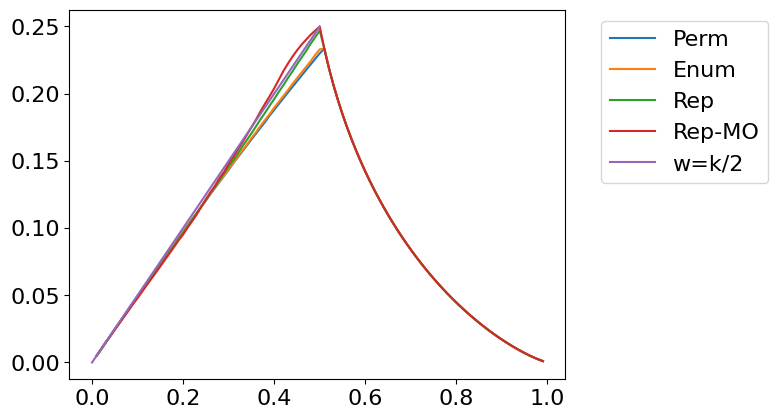

In [21]:
plot("weight", exclude=["CCJ","CCJ-MO","SD-Prange-Reg"])

### Running time of regular-ISD 

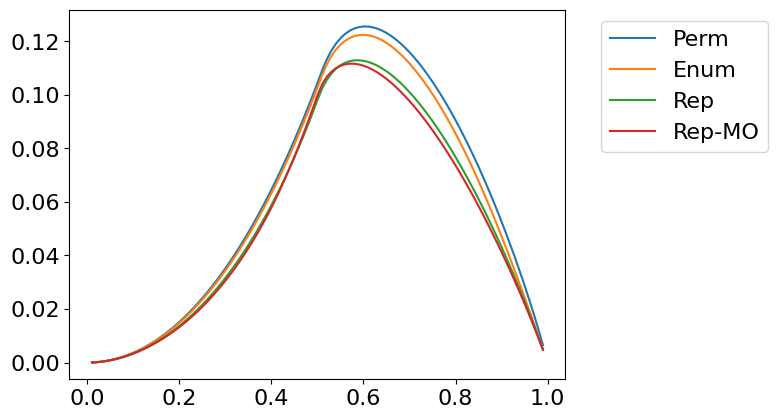

In [22]:
plot("time", exclude=["CCJ","CCJ-MO","SD-Prange-Reg"])

### Running time Rep-MO vs CCJ and Prange-Reg

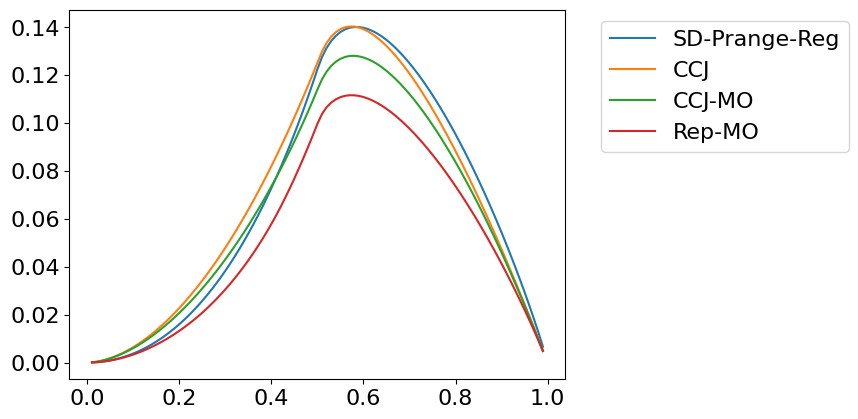

In [23]:
plot("time", exclude=["Rep","Perm","Enum"])

### Worst Case decoding exponents

In [26]:
def round_up(x,d):
    val=int(x*10**d+1)/10**d
    if val<0.0002:
        val=0
    s=str(val)
    if len(s)==1:
        s+="." 
    while len(s)<6:
        s+="0"
    return s

for i in versions:
    worst= max(versions[i]["data"], key = lambda x: x[1][0])
    if len(i)<8:
        print(i,"\t\t&\t",worst[0],"\t&\t",round(worst[1][2],4),"\t&\t",round_up(worst[1][0],4),"\t&\t",round_up(worst[1][1],4),"\\\\")
    else:
        print(i,"\t&\t",worst[0],"\t&\t",round(worst[1][2],4),"\t&\t",round_up(worst[1][0],4),"\t&\t",round_up(worst[1][1],4),"\\\\")

SD-Prange-Reg 	&	 0.58 	&	 0.1575 	&	 0.1402 	&	 0.0000 \\
CCJ 		&	 0.57 	&	 0.1659 	&	 0.1404 	&	 0.1404 \\
CCJ-MO 		&	 0.58 	&	 0.1575 	&	 0.1281 	&	 0.1054 \\
Perm 		&	 0.6 	&	 0.1421 	&	 0.1256 	&	 0.0000 \\
Enum 		&	 0.6 	&	 0.1421 	&	 0.1225 	&	 0.0287 \\
Rep 		&	 0.59 	&	 0.1496 	&	 0.1130 	&	 0.0714 \\
Rep-MO 		&	 0.57 	&	 0.1659 	&	 0.1117 	&	 0.0852 \\
